




#      Neural Style Transfer - COPS - Week 4 - Final Project

**Installing all important dependencies**

In [46]:
# In case the notebook/env does not have the following dependencies pre-installed
# !pip install tensorflow
# !pip install opencv

# dependencies
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
 # opencv
import cv2
# a compressed form of all pretrained ML models
import tensorflow_hub as hub
# for tensorboard
import datetime, os



**TensorBoard extension**

In [47]:
# TensorBoard extension - to observe progress of training the model and see the rate of optimization

%load_ext tensorboard

import os
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


**Loading any image**

In [48]:
# function to load any image

def load_img(img_path) :
  img = tf.io.read_file(img_path) # reads binary info of img .
  img = tf.image.decode_image(img , channels=3)
  img = tf.image.convert_image_dtype(img , tf.float32)
  img = img[tf.newaxis , : ] # selects the whole image and puts it in a batch containing a single image since models are trained on batche of images
  return img



***Approach1* - BUILDING MY OWN MODEL FOR NST**

---





In [49]:
# use a fee forward cnn model (with NO set paramerters/ weights) to learn to extract features from an image
# eg  - VGG19

# PS - Due to memory limit and GPU limit , I am using here a pre-trained model that has ONLY the weights & biases set . though I planned to use cifar10 dataset for training

cnn = keras.applications.VGG19(  weights="imagenet" , include_top =False , input_shape = [512,512,3] )

# eg - EfficientNetB7

# cnn = tf.keras.applications.EfficientNetB7(  weights="imagenet" , include_top =False , input_shape = [512,512,3] )
# I disconnected the last layers of VGG19 CNN as I just want the model to learn to - how to extract the features from image ONLY and NOT classifiy/localization task


**Pre Processing the Image**

In [50]:

# pre=processing the images before training the model on it

# pre-process function
def preprocess_image(img):
  final_img = keras.applications.vgg19.preprocess_input(img)
  final_img = tf.image.resize(img , [512,512])

  # use some data augmentation also to increase the trianing set size (to prevent overfitting)

  return final_img


**For making Custom functions**

In [51]:
import keras.backend as K

In [52]:
# Our cnn1 model (new model) has been trained and it knows how to extract features from the images

cnn1 = tf.keras.models.Model(inputs=cnn.input, outputs = cnn.layers[-2].output)

**Gram Matrix Function**

In [53]:
# function to generate gram matrix for any  feature map for any layer of feed forward cnn .
# gram matrix = A . A t  => feature map dot product with its transpose


def gram_matrix(x):
  # tf.einsum() -> matrix multiplaction and its parameters are b=batch dimension , i,j = spatial dimension and c,d = instances of color channels and resuce spatial dimension and then do matrix multiplaction
  # since we want to find correlation between different patterns of style image independent of the location of the apattern in image thats why , we eliinate i,j from image .
  res = tf.einsum('bijc,bijd->bcd', x, x) # it is also performing dot product of A with transpose(A).

  # its NOT image here , its a tensor (n-dimesnion matrix with some info.)
  input_shape = tf.shape(x)

  # dividing helps in providing positional invariance to tensor while CNN trains on it .
  location= tf.cast(input_shape[1] * input_shape[2], tf.float32) # tf.cast() changes the form of tensor

  return res / (location)





**My CNN Model's Summary**

In [54]:
for layer in cnn.layers :
  print(layer.name)

cnn.summary

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


<bound method Model.summary of <keras.engine.functional.Functional object at 0x7cf1a05a3a90>>

**Input Visualization**

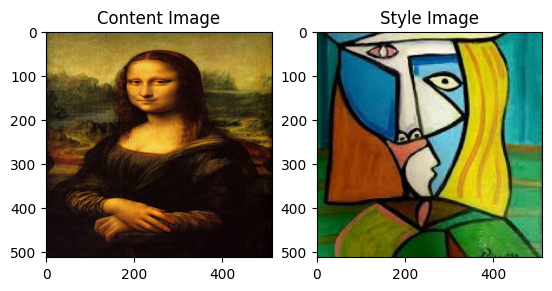

In [55]:
# loading the input - CONTENT IMAGE and STYLE (reference) Image .

style1 =  load_img("m1.jpg")
content1 = load_img("m2.jpg")


def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

preprocessed_content_image = preprocess_image(content1)
preprocessed_style_image = preprocess_image(style1)

plt.subplot(1, 2, 1)
imshow(preprocessed_content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(preprocessed_style_image, 'Style Image')



**Creaing a 'Log' Directory for Tensorboard**

In [56]:
def log_to_tensorboard(loss_val, epoch):
    with tf.summary.create_file_writer(log_dir).as_default():
        tf.summary.scalar('total_loss', loss_val, step=epoch)


In [57]:

from keras.layers import Layer

# We use Keras layer (as Layer)  for loss and gradients calculation and minimization of loss function to incoperate content + style both in thee randomly generated image .

class LossLayer(Layer):
    def __init__(self, content_layer, style_layers, content_weight, style_weight):
        super(LossLayer, self).__init__() # we use super(derived class , self) to ensure all the properties of parent class are properly copied into derived class
        self.content_layer = content_layer
        self.style_layers = style_layers

        # since we are using two loss function ,we need to assign proper weights to the content loss and style loss function .
        self.content_weight = content_weight
        self.style_weight = style_weight

    def content_loss(self, gen, content):
        c1 = cnn(content)
        g1 = cnn(gen)
        loss =  K.sum(K.square(g1 - c1))#  summation (Pij - Fij)^2
        return loss


    def style_loss(self, gen, style):

      # generate the gram matrix from feature map od=f style and gn=enerated image and calculate diff. between them .and minimize it
        gen_f = gram_matrix(cnn(gen))
        style_f = gram_matrix(cnn(style))
        channels = 3
        size = 512 * 512
        loss = K.sum(K.square(gen_f - style_f)) / (4. * (channels**2) * (size**2)) # style loss irrespective of size .s
        return loss


# PS - In both type of loss functions , we actually calculate that loss by calculating distance between the properties of feature maps of image
    def call(self, inputs):  # this call function is called implicitly with the class without any loss_layer.call since we passed all required inputs during the class definition only
        gen_img, content_img, style_imgs = inputs
        content_loss_val = (self.content_weight) * self.content_loss(gen_img, content_img)

        style_loss_val = 0.0
        for layer_name in self.style_layers:
            style_img = style_imgs[layer_name]
            style_loss_val += (self.style_weight / len(self.style_layers)) * self.style_loss(gen_img, style_img)

        loss = content_loss_val + style_loss_val
        self.add_loss(loss)
        return gen_img





**Layers of CNN for Feature Extraction**

In [ ]:
# ContentLayer (last layer of cnn) generates the feature map of content image
content_layer = "block5_conv1"

# style layers - feature map from all these layers of cnn model vgg19 is needed to compute loss function
style_layers = {
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1"
}


In [58]:
# Content image  loaded after pre-processing
content_img = preprocess_image(content1)

# Style image  loaded after pre-processing
style_img = preprocess_image(style1)


In [59]:

# iNITIALiZING the custom layer with losses

# POTENTIAL ERROR - IF YOU WANT TO CHANGE THE ARGUMENTS , ALWAYS KEEP KEYWORD ARG. BEFORE POSITIONAL ARGS LIKE HERE .
loss_layer = LossLayer(content_layer, style_layers, content_weight=0.025, style_weight=1.0)


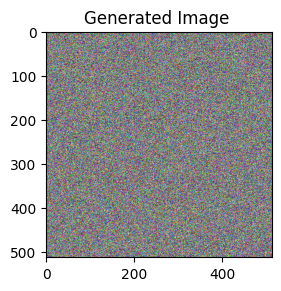

In [61]:
# Optimization using L-BFGS-B algorithm AND L-BFGS OPTIMIZER
from scipy.optimize import fmin_l_bfgs_b

# function to evaluate loss and gradients at each step/iteration

def fetch_loss_and_grads(img):
    img = img.reshape((1, 512, 512, 3))

    with tf.GradientTape() as tape: # to claculate gradient at each step
        gen_img = loss_layer(  [img, content_img, style_imgs]  )
        loss = loss_layer.losses[0]

    grads = tape.gradient(loss, gen_img)
    # if NO gradient , the already style and content consolidated in the image , so NO CHNAGE required
    if grads is None:
        grads = tf.zeros_like(gen_img)

    loss_val = loss.numpy().astype('float64')
    grads = grads.numpy().flatten().astype('float64')

    return loss_val, grads

# Disable eager execution to process the image completely NOW .
tf.config.run_functions_eagerly(False)

# Creating a dictionary to hold style images for each style layer
style_imgs = {}
for layer_name in style_layers:
    style_imgs[layer_name] = style_img

# Initialization of q randomly generated image generated image
gen_img = np.random.rand(512,512,3)


gen_img_value = gen_img.flatten()

# iterate to minimize this (content+style) loss using L-BFGS Algorithm

# PS - IF YOU HAVE A LOW POWERED GPU , THEN TRY THE ADAM OPTIMIZER instead USING
# keras.optimizer.Adam(learning_rate=0.01) as theL-BFGS OPTIMIZER PROVE TO BE QUITE COMPUTATIONALY EXPENSIVE .

epochs = 10 # feel free to play with epochs

for epoch in range(epochs):
    gen_img_value, loss_val, info = fmin_l_bfgs_b(fetch_loss_and_grads, gen_img_value)
    gen_img = gen_img_value.reshape((1, 512, 512, 3))
    log_to_tensorboard(loss_val, epoch)


# Re-enable eager execution - Now all the code wis processed instantly
tf.config.run_functions_eagerly(True)

# Reshape the optimized image to display - (since spatial dimension were changed during compuattion) (pass the tensor shape as a tuple )
optimized_img = gen_img.reshape((512, 512, 3))

# Display the optimized image

plt.subplot(1, 2, 1)
imshow(optimized_img, 'Generated Image ')



**Generating the Last Feature Map of Content & Style Image from the Same VGG19 Model**

1/1 [==============================] - 3s 3s/step


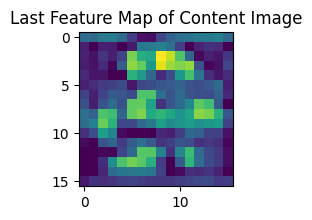

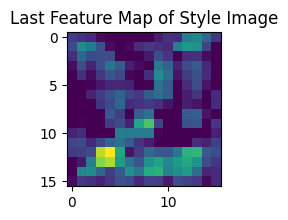

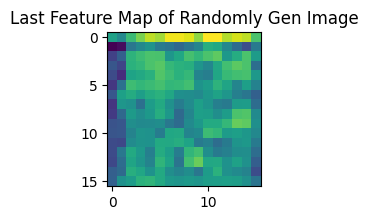

In [62]:

last_layer_model = keras.models.Model(inputs=cnn.input, outputs=cnn.layers[-1].output)
feature_map_con = last_layer_model.predict(content_img)

feature_map_sty= last_layer_model.predict(style_img)

feature_map_gen= last_layer_model.predict(gen_img)

# Plot the last feature map
plt.figure(figsize=(2,2))
plt.imshow(feature_map_con[0, :, :, 0])
plt.title('Last Feature Map of Content Image')
plt.show()

plt.figure(figsize=(2,2))
plt.imshow(feature_map_sty[0, :, :, 0])
plt.title('Last Feature Map of Style Image')
plt.show()

plt.figure(figsize=(2,2))
plt.imshow(feature_map_gen[0, :, :, 0])
plt.title('Last Feature Map of Randomly Gen Image')
plt.show()

In [ ]:
%tensorboard --logdir logs --port=6006

**Importing a Pre-Trained and Coded Stylization Model for NST (Neural Style Transfer**

In [63]:
# load the style transfer model (pre-trained model)

model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

**Load any Image**

In [64]:
# function to load any image

def load_img(img_path) :
  img = tf.io.read_file(img_path) # reads binary info of img .
  img = tf.image.decode_image(img , channels=3)
  img = tf.image.convert_image_dtype(img , tf.float32)
  img = img[tf.newaxis , : ] # selects the whole image and puts it in a batch containing a single image since models are trained on batches of images
  return img

In [65]:
# Loading our actual images

content_image = load_img("m2.jpg")
style_image = load_img("m1.jpg")




**Preprocessing the input**

In [66]:
# function to pre-process the content and style image  -> to standardize the pixel intensity as Normal distribution and resize the image to desired size

def preprocess_img(img):
  final_img = keras.applications.vgg19.preprocess_input(img)
  final_img = tf.image.resize(img , [512,512])
  return final_img


In [67]:
content_image = preprocess_img(content_image)

style_image = preprocess_img(style_image)



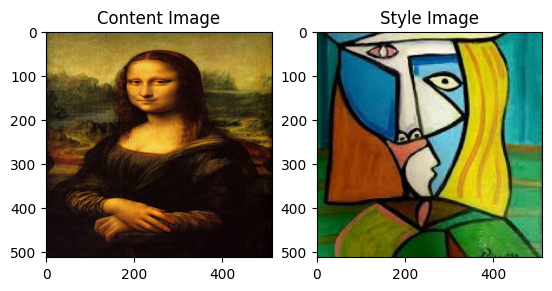

In [68]:
# loading the input - CONTENT IMAGE and STYLE (reference) Image .

style1 =  load_img("m1.jpg")
content1 = load_img("m2.jpg")


def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

preprocessed_content_image = preprocess_image(content1)
preprocessed_style_image = preprocess_image(style1)

plt.subplot(1, 2, 1)
imshow(preprocessed_content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(preprocessed_style_image, 'Style Image')

**Performing the NST**

In [69]:
# performing the Neural Style transfer(NST) rusing pre-trained model for NST , exctract info from style image and apply it on all parts of content image
# using model(content image , style img )[0] ==> [0] to extract first result of generate img batch

generated_img  = model(tf.constant(content_image) , tf.constant(style_image))[0]


**Output Visualization**

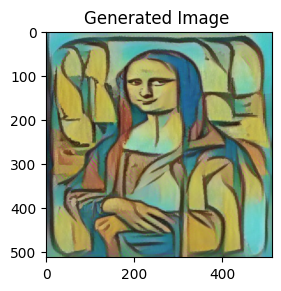

In [70]:
# visulaizing ( showing the genrated / stylized iamge)

plt.subplot(1, 2, 1)
imshow(generated_img, 'Generated Image ')

**Saving the image**

In [71]:
# saving the image

cv2.imwrite("final.jpg" ,cv2.cvtColor(np.squeeze(generated_img) , cv2.COLOR_BGR2RGB))

True

In [ ]:
# Concept of NST ( Neural Style transfer)


'''
a CNN (which is actually VGG net used to classify large scale images ) first extracts all features from a style reference image by picking the result of
a particular conv layer (which is a feature map of style image)(G matrix ) and publishing it as a gram matrix ( dot product - inner product of 2 feature maps )
and all such feature maps of style image form a feature space . Now , the model (VGG net) works on input content image and it also extract its features
in form of feature maps ( F matrix). Now , a loss function minimizes the loss between G and F matrix (style and content image using L-BFG/Adam optimizer ) and trains to find
best parameters of model for such condition by changing G matrix mainly and hence , we retain the content of input content image while also applying style to it .

GRAM MATRIX FORMULA :  [G]ij = < vi , vj > => i th row and j th col elemnt of a gram matrix = dot product of i th feature and jth feature
 So , the diagonal is the brightest line on gram matrix since i=j here and any feature vi is MOST CLOSELY RELATED to itself hence v i * vi => max

As we go deeper in cnn , the intensity of pixels reduce since spatial dimesnion reduce and images instead become deeper with more channels

'''


'''
The CNN for NST uses a VGG net . and puts both the content and the style image in VGG net and we know that after each layer of convolsion of vgg net ,
we get a feature map of both the content and style imag (with several low level features highlited in it )  and it also constructs their corresponding  Gram matrices ( which show the
relation between diff. parts of image by their pattern - mainly in style image) and NOW , since it has been trained on several labelled images ,
it uses its knowledge to copy same pixel pattern to the content image and generate a new image after each layer of Convnet .

Now it computes a style loss function and a content loss function (to know how diff the generated image at that layer is different from original content and style image)
and it tries to find a right balance between these to create a good generated image at each layer of cnn and all these results are integrated at last layer of cnn and we get
OUR FINAL GENERATED IMAGE .
'''

# TO provide a smoother appearence to the generated image , we use - a tv loss ( Total Variation Loss ) regularization term .and prevents overfitting in the image .

# ALways try to pass an RGB content image rather than grayscale as the colors help to relate and identify more abstract and hidden features .

# IN (Instance Normalization) normalizes ( scales and normalizes the pixels of same image and NOT of a batch) the content and style image and help
# to combine style of more than 1 style image in the same content image . and due to normalization , there are NO learnable parameters of the NST model
# and we only need to find mean and variance of the content and style image and pass it through decoder (cnn) and get output image .

'''
RecoNet - Real time coherent video style transfer - uses a green screen (first frame to be stylized ) and uses it a reference now to style further frames
(since its a video) and if it deviates from the first frame's style , it penalizes it .
'''

'''

The NST built by self using an image dataset like Coco dataset - ONLY learns to extract features from it BUT combining them for NST is
 done by the model itself without any training and we just give it the instruction to minimize style and content loss for a good NST
generated image (using a feed forward CNN  generally) .
'''

# use it after training to see the progress on tewnsorboard
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)